In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime 
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


In [2]:
df = pd.read_csv('user_transactions.csv')
df['event_date']=df.event_date.apply(date_converter)
df['avg']=df.amount/df.transactions

#### 1) Изучение данных 

In [3]:
df.head()

,event_date,user_id,product,amount,transactions,avg
0,2020-09-29,40746820883461494,basic,95.0,1,95.0
1,2020-09-29,41102328408008828,advanced,279.0,1,279.0
2,2020-09-29,63464894315144075,basic,64.0,1,64.0
3,2020-09-29,111526991873455341,basic,399.0,1,399.0
4,2020-09-29,169522572963414231,basic,199.0,1,199.0


Выделим основные метрики для проверки гипотез:
    
    1) число транзакций с одного пользоватедля
    
    2) средний чек с одной транзакции 
    
    3) долю advanced тарифа

Также будем использовать разбивку по месяцам и типу тарифа 

Посмотрим, как распределены данные в разрезе тарифа:

In [4]:
df_basic=df[df['product'] == 'basic']

In [5]:
df_basic.describe(percentiles=[0.25,0.50,0.75,0.95])

,user_id,amount,transactions,avg
count,9.904280e+05,990428.000000,990428.000000,990428.000000
mean,4.617406e+18,164.003625,1.296846,127.697391
std,2.660018e+18,233.032281,1.527605,77.028749
min,1.912220e+12,8.000000,1.000000,8.000000
25%,2.309786e+18,80.000000,1.000000,76.000000
50%,4.623599e+18,120.000000,1.000000,100.000000
75%,6.915631e+18,199.000000,1.000000,169.000000
95%,8.768598e+18,399.000000,3.000000,270.000000
max,9.223362e+18,108186.000000,768.000000,529.000000


In [6]:
df_advanced=df[df['product'] == 'advanced']

In [7]:
df_advanced.describe(percentiles=[0.25,0.50,0.75,0.95])

,user_id,amount,transactions,avg
count,2.877580e+05,287758.000000,287758.000000,287758.000000
mean,4.603347e+18,499.179714,1.278383,388.828622
std,2.646895e+18,583.444202,1.453016,261.807085
min,1.809139e+12,20.000000,1.000000,20.000000
25%,2.321055e+18,202.000000,1.000000,199.000000
50%,4.620357e+18,369.000000,1.000000,330.000000
75%,6.880639e+18,599.000000,1.000000,527.000000
95%,8.746025e+18,1338.000000,3.000000,839.000000
max,9.223367e+18,40653.000000,227.000000,1869.000000


Видим, что у нас basic клиентов сильно больше, чем advanced и при этом средняя сумма транзакции у advanced выше, следовательно, при проведении эксперимента было бы логично их разбить по типу тарифа. Построим графики:

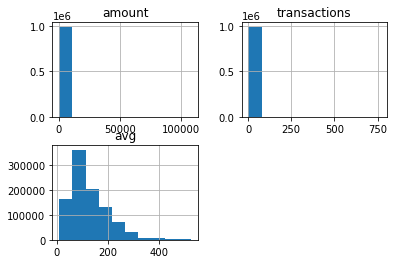

In [8]:
#для базового тарифа 
h = df_basic[['amount','transactions','avg']].hist()

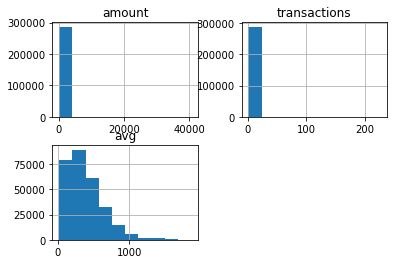

In [9]:
#для продвинутого тарифа 
h = df_advanced[['amount','transactions','avg']].hist()

Видим, что данные имеют выбросы в виде экстремально больших значений - максимумы очень сильно отличаются от величины 95 перцентиля. Поэтому избавимся от них для того чтобы прийти к более точным выводам и уменьшить длительность эксперимента. Возьмем только те данные которые меньше 99 перцентиля.

In [10]:
#для продвинутого тарифа 
quantil_amount_advanced=np.quantile(df_advanced['amount'],q=0.99)
quantil_transactions_advanced=np.quantile(df_advanced['transactions'],q=0.99)
df_clear_advanced=df_advanced[(df_advanced['amount']<quantil_amount_advanced)&(df_advanced['transactions']<quantil_transactions_advanced)]

In [11]:
#для базового тарифа 
quantil_amount_basic=np.quantile(df_basic['amount'],q=0.99)
quantil_transactions_basic=np.quantile(df_basic['transactions'],q=0.99)
df_clear_basic=df_basic[(df_basic['amount']<quantil_amount_basic)&(df_basic['transactions']<quantil_transactions_basic)]

In [12]:
#для продвинутого тарифа
df_clear_advanced.describe(percentiles=[0.25,0.50,0.75,0.95])

,user_id,amount,transactions,avg
count,2.834240e+05,283424.00000,283424.000000,283424.000000
mean,4.604299e+18,454.52251,1.176206,386.359909
std,2.648822e+18,370.25482,0.545962,258.622599
min,1.809139e+12,20.00000,1.000000,20.000000
25%,2.319140e+18,200.00000,1.000000,199.000000
50%,4.619777e+18,368.00000,1.000000,330.000000
75%,6.886519e+18,579.00000,1.000000,505.666667
95%,8.748363e+18,1160.00000,2.000000,839.000000
max,9.223367e+18,2799.00000,5.000000,1869.000000


In [13]:
#для базового тарифа
df_clear_basic.describe(percentiles=[0.25,0.50,0.75,0.95])

,user_id,amount,transactions,avg
count,9.759070e+05,975907.000000,975907.000000,975907.000000
mean,4.616768e+18,148.724722,1.189708,127.059368
std,2.660913e+18,106.774083,0.555754,76.244270
min,1.912220e+12,8.000000,1.000000,8.000000
25%,2.308468e+18,79.000000,1.000000,76.000000
50%,4.622589e+18,119.000000,1.000000,100.000000
75%,6.916333e+18,191.000000,1.000000,169.000000
95%,8.768086e+18,358.000000,2.000000,269.000000
max,9.223362e+18,812.000000,5.000000,529.000000


построим графики для отчищенных данных 

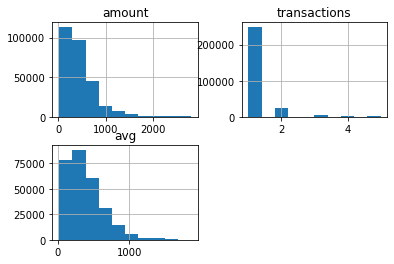

In [14]:
#для продвинутого тарифа 
h = df_clear_advanced[['amount','transactions','avg']].hist()

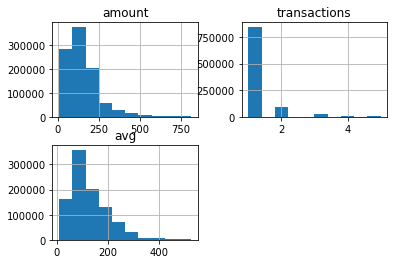

In [15]:
#для базового тарифа 
h = df_clear_basic[['amount','transactions','avg']].hist()

Посмотрим как изменялась доля advanced тарифа каждый день:

In [16]:
df_fr_advanced=df_advanced.groupby(['event_date']).agg({'amount':['count']})/df.groupby(['event_date']).agg({'amount':['count']})

In [17]:
df_fr_advanced=df_fr_advanced['amount']

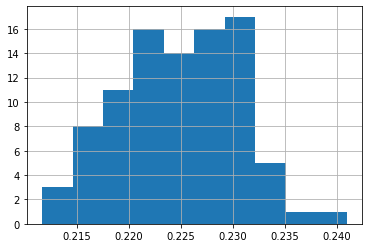

In [18]:
h = df_fr_advanced['count'].hist()

##### Выводы:

     1) Данные имеют выбросы
     
     2) Распределения 'amount','transactions' и 'avg' похоже на экспоненциальное, распределение у доли advanced тарифа похоже на нормальное 
     
     3) Убрав выбросы мы можем снизить дисперсию, тем самым снизить срок эксперимента 
     
     4) Данные по типу тарифа сильно отличаются имеет смысл рассматривать их отдельно

    

#### Сезональность:

Для того чтобы посмотреть сезональность данных, посмотрим, как меняются распределения от месяца к месяцу:

In [52]:
df['m']=df['event_date'].dt.month

In [65]:
agg_func_math = {
    'amount': ['count','sum', 'mean', 'min', 'max', 'std'],
    'transactions': ['count','sum', 'mean', 'min', 'max', 'std'],
    'avg':['count','sum', 'mean', 'min', 'max', 'std']
}

Посмотрим как изменяются средние:

In [66]:
df.groupby(['product','m']).agg(agg_func_math)

amount                                                      \
              count         sum        mean   min       max         std   
product  m                                                                
advanced 9     6073   2885482.0  475.132883  28.0   13440.0  572.852026   
         10   88832  42143831.0  474.421729  20.0   18012.0  509.657963   
         11   92981  47142133.0  507.008238  20.0   40653.0  646.098318   
         12   99872  51471510.0  515.374780  20.0   18960.0  583.336764   
basic    9    20569   3403173.0  165.451553   8.0    5514.0  178.061147   
         10  306483  49915612.0  162.865842   8.0  108186.0  274.617866   
         11  319955  52525541.0  164.165401   8.0   15876.0  204.161100   
         12  343421  56589456.0  164.781583   8.0   15518.0  220.398749   

            transactions                                          avg  \
                   count     sum      mean min  max       std   count   
product  m                                                              
advanced 9          6073    7569  1.246336   1   60  1.267141    6073   
         10        88832  111405  1.254109   1   60  1.027922   88832   
         11        92981  120288  1.293684   1  227  1.975945   92981   
         12        99872  128603  1.287678   1   95  1.187365   99872   
basic    9         20569   26123  1.270018   1   37  1.142048   20569   
         10       306483  393756  1.284756   1  768  1.872112  306483   
         11       319955  414665  1.296010   1   87  1.280657  319955   
         12       343421  449889  1.310022   1   95  1.412712  343421   

                                                                 
                      sum        mean   min     max         std  
product  m                                                       
advanced 9   2.290036e+06  377.084852  28.0  1869.0  269.417199  
         10  3.344750e+07  376.525312  20.0  1869.0  255.725234  
         11  3.645747e+07  392.095872  20.0  1869.0  262.753886  
         12  3.969355e+07  397.444204  20.0  1869.0  265.347423  
basic    9   2.709825e+06  131.743173   8.0   529.0   80.714433  
         10  3.937058e+07  128.459256   8.0   529.0   77.354914  
         11  4.087882e+07  127.764280   8.0   529.0   76.713251  
         12  4.351585e+07  126.712833   8.0   529.0   76.788280

#### Вывод:
В сентябре видны отличия видны из-за того, что о нем мало данных, поэтому его в расчёт не берем. Если смотреть на 3 последних месяца, то можем считать, что наш продукт не особо сезонный

#### 2) Формализуйте гипотезы 

##### Гипотеза 1: Дополнительное информирование об эффективности услуг будет стимулировать их покупку


Для проверки данной гипотезы мы будем рассматривать метрику transactions - количество транзакций для каждого тарифа. Сравним среднее число транзакций в тесте и контроле. Также будем смотреть чтобы при этом не упал средний чек и количество покупок (пользователи не ушли от нашей назойливости).

По данным видно, что количество транзакций за месяц очень большое и если мы добьемся относительного прироста в 1%, то мы молодцы))  


##### Гипотеза 2: Повышение цены базового продукта должно стимулировать покупку продвинутого продукта

Для проверки данной гипотезы мы будем рассматривать средний чек, так как если доля покупок Advanced вырастит то и средний чек тоже, при этом важно чтобы не упала суммарное число покупок.

Относительной изменение 1% к текущей.

Но вообще нужно спрашивать у бизнеса сколько они хотят)

#### 3) Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала:

### MDE:

Посмотрим каким будет MDE при проведении эксперимента внутри квартала, для этого воспользуемся формулой: 

$\text{MDE%}  =\dfrac{ (t_\alpha + t_\beta) \cdot \hat{\text{SEM}}} {\bar{X}}$

In [22]:
from scipy.stats import t,sem

In [64]:
#для 2-х сторонней гипотезы
def mde(df, alpha, power, metrics):
    mde = (t(len(df)).ppf(1 - alpha/2) + t(len(df)).ppf(power)) * sem(df[metrics])/df[metrics].mean()
    return mde 

Посимотрим MDE для transactions:

In [65]:
#на всей выборке 
mde(df, alpha=0.01, power=0.8, metrics='transactions')

0.0035336207785453887

In [66]:
# на базовом тарифе без убирания выбросов 
mde(df_basic, alpha=0.01, power=0.8, metrics='transactions')

0.0040449585558195

In [67]:
# на базовом тарифе c убирания выбросов 
mde(df_clear_basic, alpha=0.01, power=0.8, metrics='transactions')

0.001615999764769945

Посимотрим MDE для amount:

In [68]:
#на всей выборке 
mde(df, alpha=0.01, power=0.8, metrics='amount')

0.004694609895674418

In [69]:
# на базовом тарифе без убирания выбросов 
mde(df_basic, alpha=0.01, power=0.8, metrics='amount')

0.004879261563360905

In [70]:
# на базовом тарифе c убирания выбросов 
mde(df_clear_basic, alpha=0.01, power=0.8, metrics='transactions')

0.001615999764769945

Посимотрим MDE для avg:

In [71]:
#на всей выборке 
mde(df, alpha=0.01, power=0.8, metrics='avg')

0.0028961372090089846

In [72]:
# на базовом тарифе без убирания выбросов 
mde(df_basic, alpha=0.01, power=0.8, metrics='avg')

0.0020713919250410877

In [73]:
# на базовом тарифе c убирания выбросов 
mde(df_clear_basic, alpha=0.01, power=0.8, metrics='avg')

0.0020758655877688033

Вывод: разбиении по тарифам не дает сильного уменьшение MDE, если мы ожидаем прироста порядка 1%, то мы его увидим и на всей выборке с чувствительностью 80%, при этом если использовать всю выборку, то мы сможем учесть всех пользователей.

##### Наиболее оптимальный план экспериментов:

Если у нас есть возможность тестировать целый квартал, то данных достаточно для того чтобы заметить даже маленькие изменения в метриках.

Но если такой возможности нет, и мы не хотим раскатывать тест и контроль 50 на 50(что для второй гипотезы опасно), то у нас есть вариант разбить наши данные по типу подписки, и убрать из эксперимента экстремально больших пользователей(до эксперимента). 

Так например если мы хотим эксперимент длительностью неделя MDE на всех данных будет:

In [74]:
#на всей выборке 
mde(df[df.event_date < '2020-10-5'], alpha=0.01, power=0.8, metrics='transactions')

0.02978098375038118

Что больше чем ожидаемый 1% 

In [75]:
# на базовом тарифе c убирания выбросов 
mde(df_clear_basic[df_clear_basic.event_date < '2020-10-5'], alpha=0.01, power=0.8, metrics='transactions')

0.006493983651384404

А с убиранием выбросов и рассмотрением каждой подписки отдельно MDE нас устраивает 

### Оптимизация плана:

Если хотим ускорить эксперимент: 
   
   1) Можно замени 2-х стороннюю гипотезу на одностороннюю, так как по логике ничем кроме потерь на рассылку нам это не грози (для первой гипотезы), для второй лучше так не делать 
   
   2) Провести стратификацию, разбить пользователей по группам, тем самым снизить дисперсию